# Nacitanie kniznic

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, BatchNormalization, GRU, TimeDistributed, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# Nacitanie dat 

In [6]:
amp_windows_positive = pd.read_csv("amp_windows_positive_6h.csv", index_col=0)
amp_windows_negative = pd.read_csv("amp_windows_negative_6h.csv", index_col=0)

def extract_features(row):
    amplitudes = np.array(row)
    return {
        "A_base": amplitudes
    }

amp_windows_positive['A_base'] = amp_windows_positive['A_base'].apply(eval)
features = amp_windows_positive['A_base'].apply(extract_features)
features_df = pd.DataFrame(list(features))
data = pd.concat([features_df, amp_windows_positive['is_eq']], axis=1)

amp_windows_negative['A_base'] = amp_windows_negative['A_base'].apply(eval)
features = amp_windows_negative['A_base'].apply(extract_features)
features_df = pd.DataFrame(list(features))
data = pd.concat([features_df, amp_windows_negative['is_eq']], axis=1)

In [ ]:
amp_windows_positive.head(1)

In [8]:
print(len(amp_windows_positive))
print(len(amp_windows_negative))

511
351


# Logistická regresia

In [9]:
# rozdelenie na trenovaciu a testovaciu mnozinu, normalizacia
amp_windows_positive_sample = amp_windows_positive.sample(351)
amp_windows_negative_sample = amp_windows_negative.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array(data["A_base"].to_list())

scaler = MinMaxScaler(feature_range=(0, 1))
X = np.array([scaler.fit_transform(seq.reshape(-1, 1)).flatten() for seq in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# modelovanie
model = LogisticRegression(solver="liblinear", max_iter=120, C=0.5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.69      0.63        62
           1       0.71      0.59      0.65        79

    accuracy                           0.64       141
   macro avg       0.64      0.64      0.64       141
weighted avg       0.65      0.64      0.64       141



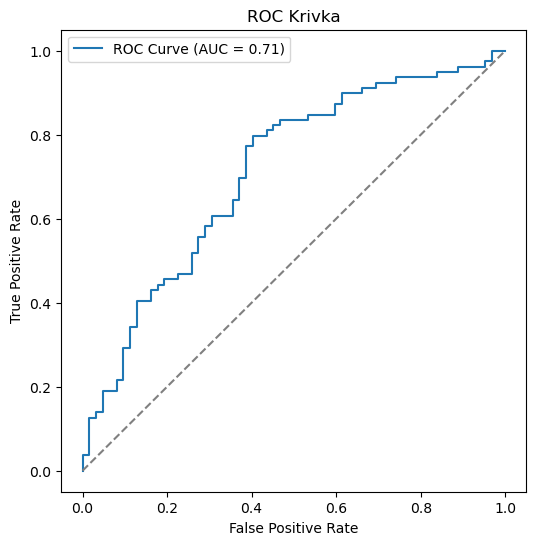

In [16]:
# ROC krivka
y_probs = model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()

In [17]:
# ulozenie modelu
with open("models/lr.pkl", "wb") as f:
    pickle.dump(model, f)

# Random forest

In [104]:
# rozdelenie na trenovaciu a testovaciu mnozinu, normalizacia
amp_windows_positive_sample = amp_windows_positive.sample(351)
amp_windows_negative_sample = amp_windows_negative.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array(data["A_base"].to_list())

scaler = MinMaxScaler(feature_range=(0, 1))
X = np.array([scaler.fit_transform(seq.reshape(-1, 1)).flatten() for seq in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# modelovanie
train_scores = []
test_scores = []
y_pred_list = []
n_trees = np.arange(50, 251, 50)
n_max_depth = np.arange(2, 10, 2)

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n,  max_depth=6, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, model.predict(X_train))
    
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    y_pred_list.append(y_pred)

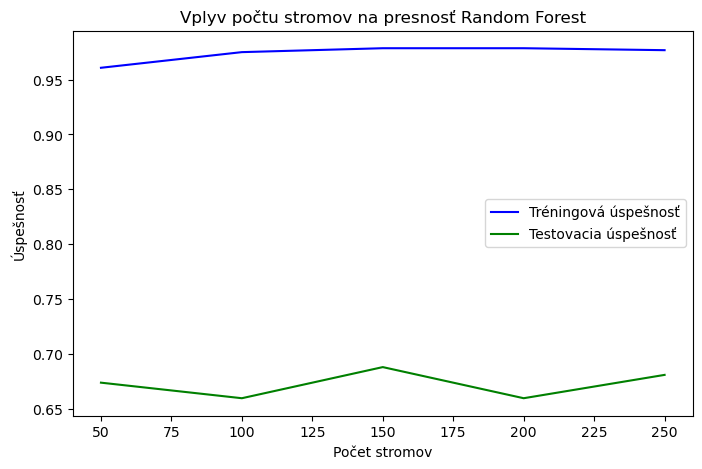

Classification Report #0:
              precision    recall  f1-score   support

           0       0.60      0.72      0.66        61
           1       0.75      0.64      0.69        80

    accuracy                           0.67       141
   macro avg       0.68      0.68      0.67       141
weighted avg       0.69      0.67      0.68       141

Classification Report #1:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64        61
           1       0.74      0.62      0.68        80

    accuracy                           0.66       141
   macro avg       0.66      0.66      0.66       141
weighted avg       0.67      0.66      0.66       141

Classification Report #2:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        61
           1       0.76      0.66      0.71        80

    accuracy                           0.69       141
   macro avg       0.69      0.69      0.69       

In [106]:
# priebeh ucenia na zaklade zvoleneho hyperparametra
plt.figure(figsize=(8, 5))
plt.plot(n_trees, train_scores, label="Tréningová úspešnosť", color="blue")
plt.plot(n_trees, test_scores, label="Testovacia úspešnosť", color="green")
plt.xlabel("Počet stromov")
plt.ylabel("Úspešnosť")
plt.title("Vplyv počtu stromov na presnosť Random Forest")
plt.legend()
plt.show()

for i, pred in enumerate(y_pred_list):
    print(f"Classification Report #{i}:")
    print(classification_report(y_test, pred))

In [22]:
# vyber najlepsej hodnoty hyperparametra a trening modelu s touto hodnotou
model = RandomForestClassifier(n_estimators=150,  max_depth=6, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

train_acc = accuracy_score(y_train, model.predict(X_train))

y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

train_scores.append(train_acc)
test_scores.append(test_acc)
y_pred_list.append(y_pred)

print("Classification Report:")
print(classification_report(y_test, pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.73      0.63        62
           1       0.72      0.56      0.63        79

    accuracy                           0.63       141
   macro avg       0.64      0.64      0.63       141
weighted avg       0.65      0.63      0.63       141



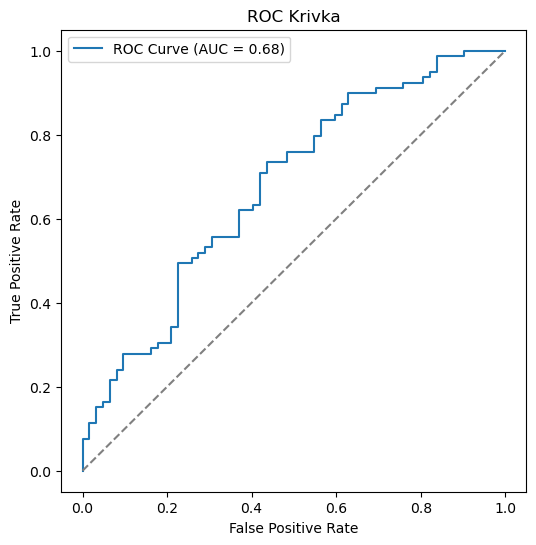

In [23]:
# ROC krivka
y_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()

In [24]:
# ulozenie modelu
with open("models/rf.pkl", "wb") as f:
    pickle.dump(model, f)

# K-nn

In [107]:
# rozdelenie na trenovaciu a testovaciu mnozinu, normalizacia
amp_windows_positive_sample = amp_windows_positive.sample(351)
amp_windows_negative_sample = amp_windows_negative.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array(data["A_base"].to_list())

scaler = MinMaxScaler(feature_range=(0, 1))
X = np.array([scaler.fit_transform(seq.reshape(-1, 1)).flatten() for seq in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# modelovanie
train_scores = []
test_scores = []
y_pred_list = []
neighbors = np.arange(4, 17, 2)

for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n, weights="distance", metric="cosine")
    model.fit(X_train, y_train)

    # úspešnosť na tréningovej a testovacej množine
    train_acc = accuracy_score(y_train, model.predict(X_train))
    
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    y_pred_list.append(y_pred)

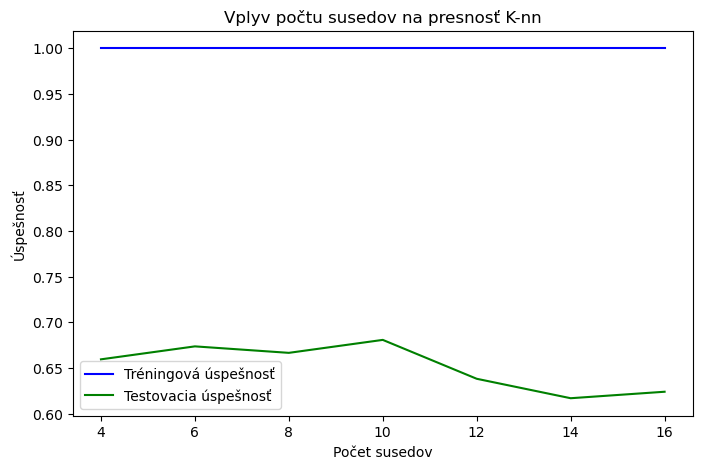

Classification Report #0:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        73
           1       0.66      0.62      0.64        68

    accuracy                           0.66       141
   macro avg       0.66      0.66      0.66       141
weighted avg       0.66      0.66      0.66       141

Classification Report #1:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        73
           1       0.66      0.66      0.66        68

    accuracy                           0.67       141
   macro avg       0.67      0.67      0.67       141
weighted avg       0.67      0.67      0.67       141

Classification Report #2:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        73
           1       0.66      0.63      0.65        68

    accuracy                           0.67       141
   macro avg       0.67      0.67      0.67       

In [109]:
# priebeh ucenia na zaklade zvoleneho hyperparametra
plt.figure(figsize=(8, 5))
plt.plot(neighbors, train_scores, label="Tréningová úspešnosť", color="blue")
plt.plot(neighbors, test_scores, label="Testovacia úspešnosť", color="green")
plt.xlabel("Počet susedov")
plt.ylabel("Úspešnosť")
plt.title("Vplyv počtu susedov na presnosť K-nn")
plt.legend()
plt.show()

for i, pred in enumerate(y_pred_list):
    print(f"Classification Report #{i}:")
    print(classification_report(y_test, pred))

In [28]:
# vyber najlepsej hodnoty hyperparametra a trening modelu s touto hodnotou
model = KNeighborsClassifier(n_neighbors=6, weights="distance", metric="cosine")
model.fit(X_train, y_train)

# uspesnost na tréningovej a testovacej množine
train_acc = accuracy_score(y_train, model.predict(X_train))

y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

train_scores.append(train_acc)
test_scores.append(test_acc)
y_pred_list.append(y_pred)

print("Classification Report:")
print(classification_report(y_test, pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.56      0.58        70
           1       0.59      0.63      0.61        71

    accuracy                           0.60       141
   macro avg       0.60      0.60      0.60       141
weighted avg       0.60      0.60      0.60       141



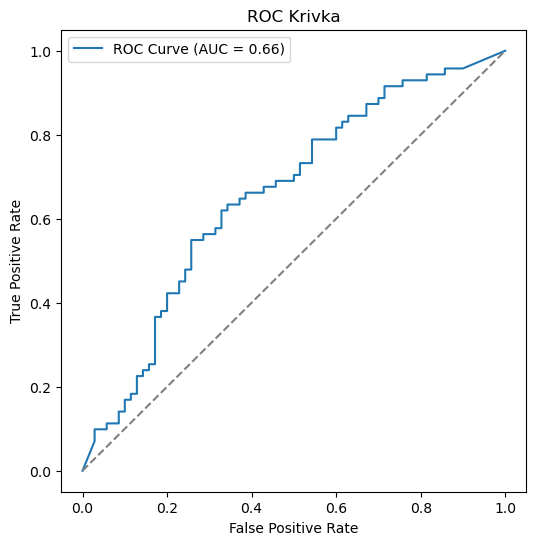

In [29]:
# ROC krivka
y_probs =  model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Náhodná klasifikácia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()

In [35]:
# ulozenie modelu
with open("models/knn.pkl", "wb") as f:
    pickle.dump(model, f)

# SVM

In [110]:
# rozdelenie na trenovaciu a testovaciu mnozinu, normalizacia
amp_windows_positive_sample = amp_windows_positive.sample(351)
amp_windows_negative_sample = amp_windows_negative.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array(data["A_base"].to_list())

scaler = MinMaxScaler(feature_range=(0, 1))
X = np.array([scaler.fit_transform(seq.reshape(-1, 1)).flatten() for seq in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
# modelovanie
train_scores = []
test_scores = []
y_pred_list = []
reg_c = np.arange(0.1, 3, 0.2)

for c in reg_c:
    model = LinearSVC(C=c, penalty='l1')
    model.fit(X_train, y_train)

    # uspesnost na tréningovej a testovacej množine
    train_acc = accuracy_score(y_train, model.predict(X_train))

    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    y_pred_list.append(y_pred)

/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

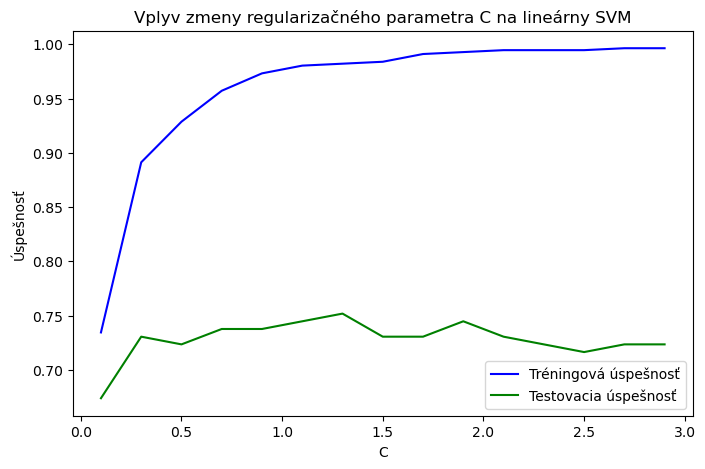

Classification Report #0:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        72
           1       0.66      0.70      0.68        69

    accuracy                           0.67       141
   macro avg       0.67      0.67      0.67       141
weighted avg       0.67      0.67      0.67       141

Classification Report #1:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        72
           1       0.71      0.75      0.73        69

    accuracy                           0.73       141
   macro avg       0.73      0.73      0.73       141
weighted avg       0.73      0.73      0.73       141

Classification Report #2:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        72
           1       0.71      0.74      0.72        69

    accuracy                           0.72       141
   macro avg       0.72      0.72      0.72       

In [112]:
# priebeh ucenia na zaklade zvoleneho hyperparametra
plt.figure(figsize=(8, 5))
plt.plot(reg_c, train_scores, label="Tréningová úspešnosť", color="blue")
plt.plot(reg_c, test_scores, label="Testovacia úspešnosť", color="green")
plt.xlabel("C")
plt.ylabel("Úspešnosť")
plt.title("Vplyv zmeny regularizačného parametra C na lineárny SVM")
plt.legend()
plt.show()

for i, pred in enumerate(y_pred_list):
    print(f"Classification Report #{i}:")
    print(classification_report(y_test, pred))

In [113]:
# vyber najlepsej hodnoty hyperparametra a trening modelu s touto hodnotou
model = LinearSVC(C=0.9, penalty='l1')
model.fit(X_train, y_train)

# uspesnost na tréningovej a testovacej množine
train_acc = accuracy_score(y_train, model.predict(X_train))

y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [114]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        72
           1       0.73      0.74      0.73        69

    accuracy                           0.74       141
   macro avg       0.74      0.74      0.74       141
weighted avg       0.74      0.74      0.74       141



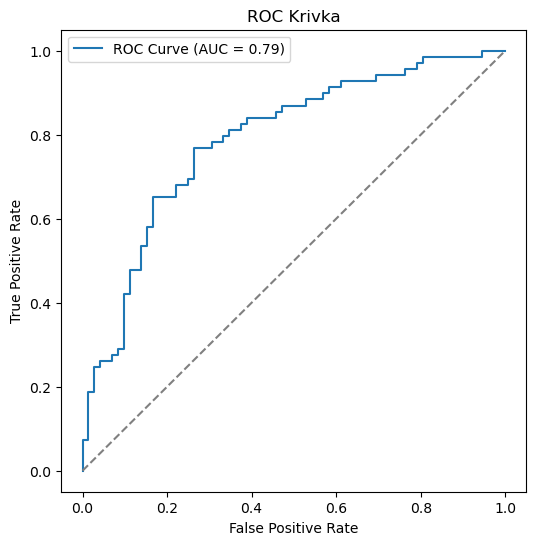

In [115]:
# ROC krivka
y_probs = model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Náhodná klasifikácia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()

In [42]:
# ulozenie modelu
with open("models/svm_cd.pkl", "wb") as f:
    pickle.dump(model, f)

# trenovanie na grafe

In [116]:
def calculate_fft_in_window(signal, sampling_rate):
    """Fourierova transformácia v danom časovom okne."""
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    positive_freq_indices = freq > 0
    freq = freq[positive_freq_indices]
    magnitude = np.abs(fft_result)[positive_freq_indices]
    
    return freq, magnitude

def extract_amplitudes_per_period(freq, magnitude, period_range):
    """Výpočet amplitúd pre zadané časové periody."""
    amplitudes = []
    for T in period_range:
        f = 1 / (T * 60)  # frekvencia pre periodu v sekundách !!!!!! zmena zo 60 na 1
        
        closest_index = np.argmin(np.abs(freq - f))
        amplitudes.append(magnitude[closest_index])
    return amplitudes

def get_period_range(window_sz, sampling_rate, num=300):
    T_max = window_sz / (2 * sampling_rate * 60)  # Perióda v minútach
    T_min = 0.1  # Minimálna perióda (6 sekúnd)
    return np.logspace(np.log10(T_min), np.log10(T_max), num=num)


sampling_rate = 10
window_size = 6 * 3600 * sampling_rate  # 6 hodin v sekundách
step_size = sampling_rate * 60 * 10   # krok okna 10 minút v sekundách

period_ranges = [get_period_range(w, sampling_rate) for w in [window_size]][0]

results_amp_pos = []
T_list_pos = []
Delta_t_list_pos = []

for amp in list(amp_windows_positive["A_base"]):
    amplitude = np.array(amp)
    time_in_seconds = np.arange(len(amplitude))
    
    time_offsets = []
    results_amp = []
    
    start_idx = 0
    end_idx = 0
    
    while end_idx < window_size:
        end_idx = start_idx + step_size
        window_signal = amplitude[start_idx:end_idx]
    
        # Vypočítame FFT v okne
        freq, magnitude = calculate_fft_in_window(window_signal, sampling_rate)
    
        # Fourierove amplitúdy pre zadané periody
        amplitudes = extract_amplitudes_per_period(freq, magnitude, period_ranges)
        results_amp.append(amplitudes)

        avg_time = (time_in_seconds[start_idx] + time_in_seconds[end_idx - 1]) / 2
        time_offsets.append((avg_time / 36000) - 3)  # časový posun v hodinách
    
        start_idx += step_size

    results_amp = np.array(results_amp)
    results_amp = results_amp / np.max(results_amp)
    time_offsets = np.array(time_offsets)
    
    T, Delta_t = np.meshgrid(period_ranges, time_offsets)

    results_amp_pos.append(results_amp)
    T_list_pos.append(T)
    Delta_t_list_pos.append(Delta_t)

In [117]:
results_amp_neg = []
T_list_neg = []
Delta_t_list_neg = []

for amp in list(amp_windows_negative["A_base"]):
    amplitude = np.array(amp)
    time_in_seconds = np.arange(len(amplitude))
    
    time_offsets = []
    results_amp = []
    
    start_idx = 0
    end_idx = 0
    
    while end_idx < window_size:
        end_idx = start_idx + step_size
        window_signal = amplitude[start_idx:end_idx]
    
        # Vypočítame FFT v okne
        freq, magnitude = calculate_fft_in_window(window_signal, sampling_rate)
    
        # Fourierove amplitúdy pre zadané periody
        amplitudes = extract_amplitudes_per_period(freq, magnitude, period_ranges)
        results_amp.append(amplitudes)

        avg_time = (time_in_seconds[start_idx] + time_in_seconds[end_idx - 1]) / 2
        time_offsets.append((avg_time / 36000) - 3)  # časový posun v hodinách
    
        start_idx += step_size

    results_amp = np.array(results_amp)
    results_amp = results_amp / np.max(results_amp)
    time_offsets = np.array(time_offsets)
    
    T, Delta_t = np.meshgrid(period_ranges, time_offsets)

    results_amp_neg.append(results_amp)
    T_list_neg.append(T)
    Delta_t_list_neg.append(Delta_t)

In [118]:
len(results_amp_neg)

351

In [119]:
amp_windows_positive_fourier = pd.DataFrame(
    {
        "A_base_fourier": results_amp_pos,
        "T": T_list_pos,
        "Delta_t": Delta_t_list_pos,
        "is_eq": 1
    }
)

amp_windows_negative_fourier = pd.DataFrame(
    {
        "A_base_fourier": results_amp_neg,
        "T": T_list_neg,
        "Delta_t": Delta_t_list_neg,
        "is_eq": 0
    }
)

In [120]:
amp_windows_positive_fourier.head(1)

,A_base_fourier,T,Delta_t,is_eq
0,"[[0.016959414285724523, 0.004074849356749887, ...","[[0.1, 0.1025385564300975, 0.10514155554768286...","[[-2.9166805555555557, -2.9166805555555557, -2...",1


## logisticka regresia

In [121]:
# rozdelenie na trenovaciu a testovaciu mnozinu
amp_windows_positive_sample = amp_windows_positive_fourier.sample(351)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# modelovanie
model = LogisticRegression(solver="liblinear", max_iter=120, C=0.5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.74      0.66        69
           1       0.68      0.53      0.59        72

    accuracy                           0.63       141
   macro avg       0.64      0.63      0.63       141
weighted avg       0.64      0.63      0.63       141



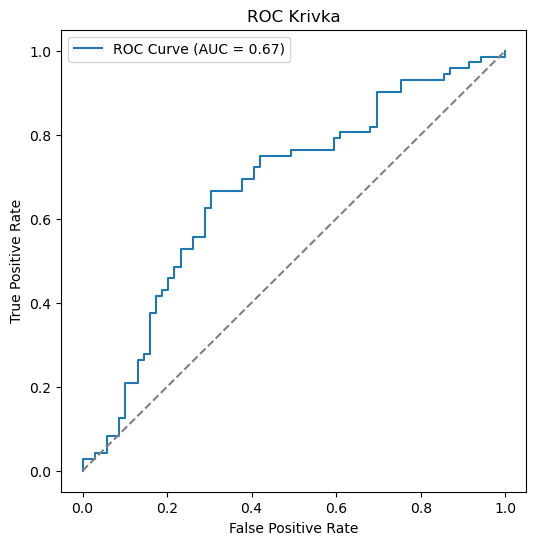

In [123]:
# ROC krivka
y_probs = model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()

In [124]:
# ulozenie modelu
with open("models/lr_fd.pkl", "wb") as f:
    pickle.dump(model, f)

## nahodne lesy

In [59]:
# rozdelenie na trenovaciu a testovaciu mnozinu
amp_windows_positive_sample = amp_windows_positive_fourier.sample(351)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# modelovanie
train_scores = []
test_scores = []
y_pred_list = []
n_trees = np.arange(10, 51, 10)
n_max_depth = np.arange(2, 11, 2)

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n,  max_depth=6, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, model.predict(X_train))
    
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    y_pred_list.append(y_pred)

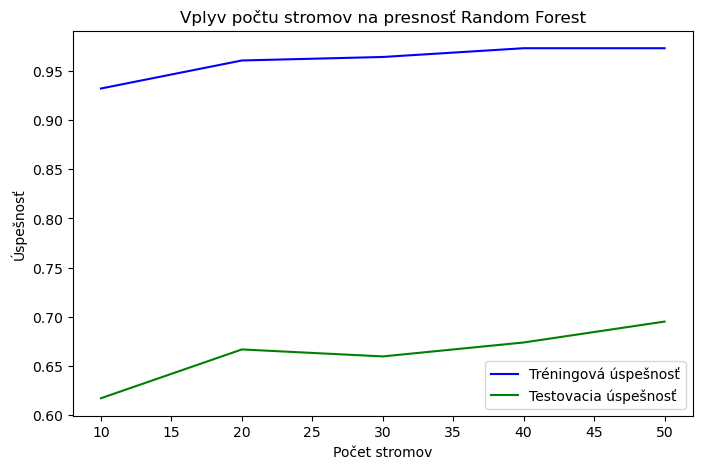

Classification Report #0:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        72
           1       0.62      0.57      0.59        69

    accuracy                           0.62       141
   macro avg       0.62      0.62      0.62       141
weighted avg       0.62      0.62      0.62       141

Classification Report #1:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        72
           1       0.68      0.61      0.64        69

    accuracy                           0.67       141
   macro avg       0.67      0.67      0.66       141
weighted avg       0.67      0.67      0.67       141

Classification Report #2:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        72
           1       0.67      0.59      0.63        69

    accuracy                           0.66       141
   macro avg       0.66      0.66      0.66       

In [70]:
# priebeh ucenia na zaklade zvoleneho hyperparametra
plt.figure(figsize=(8, 5))
plt.plot(n_trees, train_scores, label="Tréningová úspešnosť", color="blue")
plt.plot(n_trees, test_scores, label="Testovacia úspešnosť", color="green")
plt.xlabel("Počet stromov")
plt.ylabel("Úspešnosť")
plt.title("Vplyv počtu stromov na presnosť Random Forest")
plt.legend()
plt.show()

for i, pred in enumerate(y_pred_list):
    print(f"Classification Report #{i}:")
    print(classification_report(y_test, pred))

In [71]:
# vyber najlepsej hodnoty hyperparametra a trening modelu s touto hodnotou
model = RandomForestClassifier(n_estimators=20,  max_depth=6, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

train_acc = accuracy_score(y_train, model.predict(X_train))

y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

train_scores.append(train_acc)
test_scores.append(test_acc)
y_pred_list.append(y_pred)

print("Classification Report:")
print(classification_report(y_test, pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71        72
           1       0.70      0.65      0.68        69

    accuracy                           0.70       141
   macro avg       0.70      0.69      0.69       141
weighted avg       0.70      0.70      0.69       141



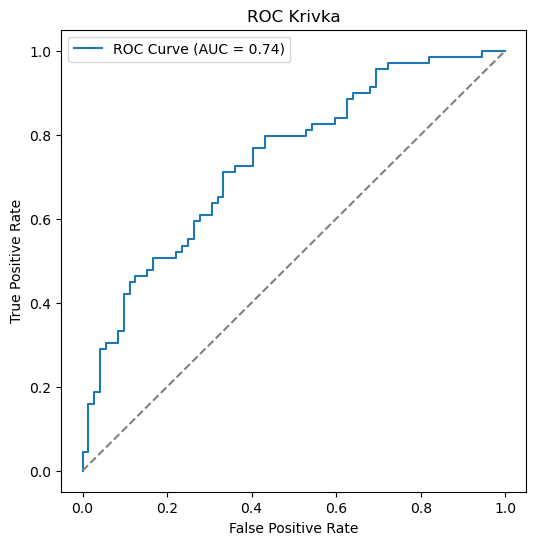

In [72]:
# ROC krivka
y_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()

In [73]:
# ulozenie modelu
with open("models/rf_fd.pkl", "wb") as f:
    pickle.dump(model, f)

## K-nn

In [74]:
# rozdelenie na trenovaciu a testovaciu mnozinu
amp_windows_positive_sample = amp_windows_positive_fourier.sample(351)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# modelovanie
train_scores = []
test_scores = []
y_pred_list = []
neighbors = np.arange(4, 11, 2)

for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n, weights="distance", metric="cosine")
    model.fit(X_train, y_train)

    # uspesnost na tréningovej a testovacej množine
    train_acc = accuracy_score(y_train, model.predict(X_train))
    
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    y_pred_list.append(y_pred)

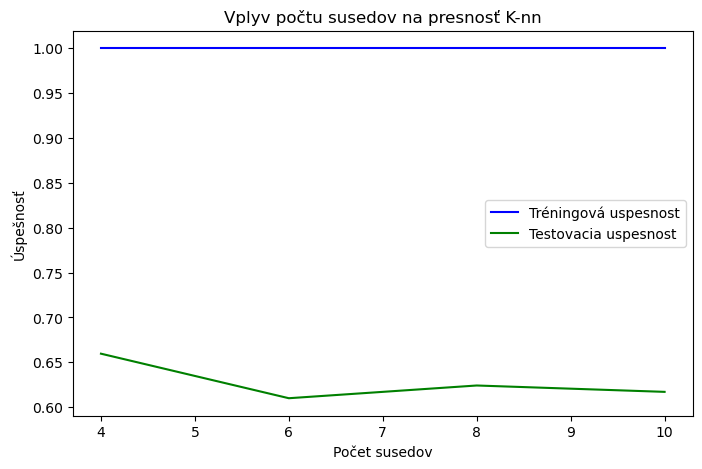

Classification Report #0:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        70
           1       0.65      0.69      0.67        71

    accuracy                           0.66       141
   macro avg       0.66      0.66      0.66       141
weighted avg       0.66      0.66      0.66       141

Classification Report #1:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        70
           1       0.60      0.66      0.63        71

    accuracy                           0.61       141
   macro avg       0.61      0.61      0.61       141
weighted avg       0.61      0.61      0.61       141

Classification Report #2:
              precision    recall  f1-score   support

           0       0.64      0.54      0.59        70
           1       0.61      0.70      0.65        71

    accuracy                           0.62       141
   macro avg       0.63      0.62      0.62       

In [80]:
# priebeh ucenia na zaklade zvoleneho hyperparametra
plt.figure(figsize=(8, 5))
plt.plot(neighbors, train_scores, label="Tréningová uspesnost", color="blue")
plt.plot(neighbors, test_scores, label="Testovacia uspesnost", color="green")
plt.xlabel("Počet susedov")
plt.ylabel("Úspešnosť")
plt.title("Vplyv počtu susedov na presnosť K-nn")
plt.legend()
plt.show()

for i, pred in enumerate(y_pred_list):
    print(f"Classification Report #{i}:")
    print(classification_report(y_test, pred))

In [81]:
# vyber najlepsej hodnoty hyperparametra a trening modelu s touto hodnotou
model = KNeighborsClassifier(n_neighbors=4, weights="distance", metric="cosine")
model.fit(X_train, y_train)

# uspesnost na tréningovej a testovacej množine
train_acc = accuracy_score(y_train, model.predict(X_train))

y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

train_scores.append(train_acc)
test_scores.append(test_acc)
y_pred_list.append(y_pred)

print("Classification Report:")
print(classification_report(y_test, pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58        70
           1       0.60      0.70      0.65        71

    accuracy                           0.62       141
   macro avg       0.62      0.62      0.61       141
weighted avg       0.62      0.62      0.61       141



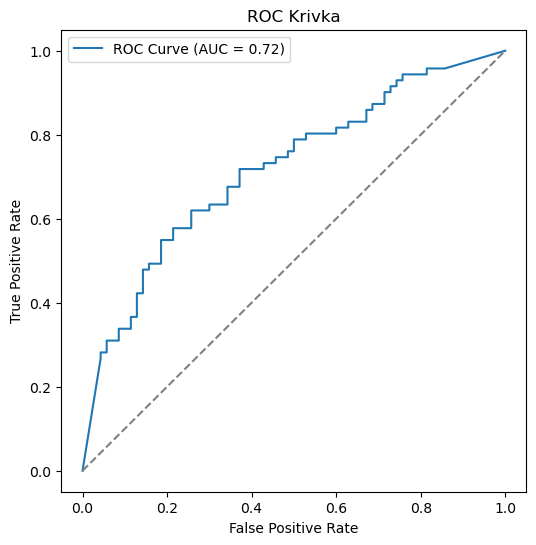

In [82]:
# ROC krivka
y_probs =  model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()

In [83]:
# ulozenie modelu
with open("models/knn_fd.pkl", "wb") as f:
    pickle.dump(model, f)

## SVC

In [85]:
# rozdelenie na trenovaciu a testovaciu mnozinu
amp_windows_positive_sample = amp_windows_positive_fourier.sample(351)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [86]:
# modelovanie
train_scores = []
test_scores = []
y_pred_list = []
reg_c = np.arange(0.1, 3, 0.2)

for c in reg_c:
    model = LinearSVC(C=c, penalty='l1')
    model.fit(X_train, y_train)

    # uspesnost na tréningovej a testovacej množine
    train_acc = accuracy_score(y_train, model.predict(X_train))

    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    y_pred_list.append(y_pred)

/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

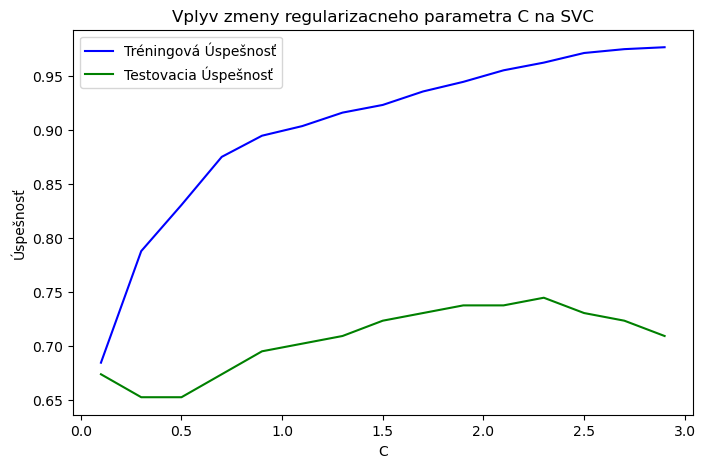

Classification Report #0:
              precision    recall  f1-score   support

           0       0.62      0.79      0.70        67
           1       0.75      0.57      0.65        74

    accuracy                           0.67       141
   macro avg       0.69      0.68      0.67       141
weighted avg       0.69      0.67      0.67       141

Classification Report #1:
              precision    recall  f1-score   support

           0       0.62      0.72      0.66        67
           1       0.70      0.59      0.64        74

    accuracy                           0.65       141
   macro avg       0.66      0.66      0.65       141
weighted avg       0.66      0.65      0.65       141

Classification Report #2:
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        67
           1       0.69      0.61      0.65        74

    accuracy                           0.65       141
   macro avg       0.66      0.65      0.65       

In [87]:
# priebeh ucenia na zaklade zvoleneho hyperparametra
plt.figure(figsize=(8, 5))
plt.plot(reg_c, train_scores, label="Tréningová Úspešnosť", color="blue")
plt.plot(reg_c, test_scores, label="Testovacia Úspešnosť", color="green")
plt.xlabel("C")
plt.ylabel("Úspešnosť")
plt.title("Vplyv zmeny regularizacneho parametra C na SVC")
plt.legend()
plt.show()

for i, pred in enumerate(y_pred_list):
    print(f"Classification Report #{i}:")
    print(classification_report(y_test, pred))

In [88]:
# vyber najlepsej hodnoty hyperparametra a trening modelu s touto hodnotou
model = LinearSVC(C=2.3, penalty='l1')
model.fit(X_train, y_train)

# uspesnost na tréningovej a testovacej množine
train_acc = accuracy_score(y_train, model.predict(X_train))

y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

train_scores.append(train_acc)
test_scores.append(test_acc)
y_pred_list.append(y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.74        67
           1       0.76      0.74      0.75        74

    accuracy                           0.74       141
   macro avg       0.74      0.74      0.74       141
weighted avg       0.75      0.74      0.74       141



/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


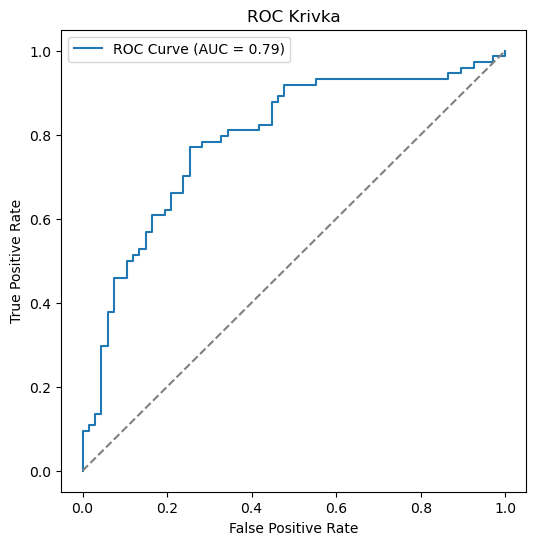

In [89]:
# ROC krivka
y_probs = model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()

In [90]:
model

LinearSVC(C=2.3, penalty='l1')

In [91]:
# ulozenie modelu
with open("models/svm_fd.pkl", "wb") as f:
    pickle.dump(model, f)